Usage of example from

https://builtin.com/data-science/time-series-forecasting-python

In [1]:
# import the data-reader from the Pandas library
import datetime

In [2]:
#  import the Pandas library itself and relax the display limits on columns and rows
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Import the data from the csv file to check if it was saved correctly
station_data = pd.read_csv("W_IMB_FAC_btw_pos_3_and_5_Jefferson_Dr_&_14th_St_SW.csv")
print(station_data.head())

   YEAR  WEEK                    STATION  COUNT_PICKUP  COUNT_RETURN  BALANCE  \
0  2021     1  Jefferson Dr & 14th St SW         111.0         138.0     27.0   
1  2021     2  Jefferson Dr & 14th St SW          22.0          24.0      2.0   
2  2021     3  Jefferson Dr & 14th St SW          54.0          74.0     20.0   
3  2021     4  Jefferson Dr & 14th St SW          43.0          47.0      4.0   
4  2021     5  Jefferson Dr & 14th St SW          66.0          60.0     -6.0   

   CAPACITY  IMBALANCE_FACTOR  TURNOVER  
0        23               1.2       0.7  
1        23               0.1       0.1  
2        23               0.9       0.3  
3        23               0.2       0.3  
4        23              -0.3       0.4  


In [4]:
# Combine 'YEAR' and 'WEEK' into a single datetime index
station_data['DATE'] = station_data['YEAR'].astype(str) + '-W' + station_data['WEEK'].astype(str)
station_data['DATE'] = pd.to_datetime(station_data['DATE'] + '-1', format='%Y-W%U-%w')

# Set the 'DATE' column as the index
station_data.index = station_data['DATE']

# Drop the 'YEAR', 'WEEK', and 'DATE' columns as they are no longer needed
station_data.drop(columns=['YEAR', 'WEEK', 'DATE'], inplace=True)

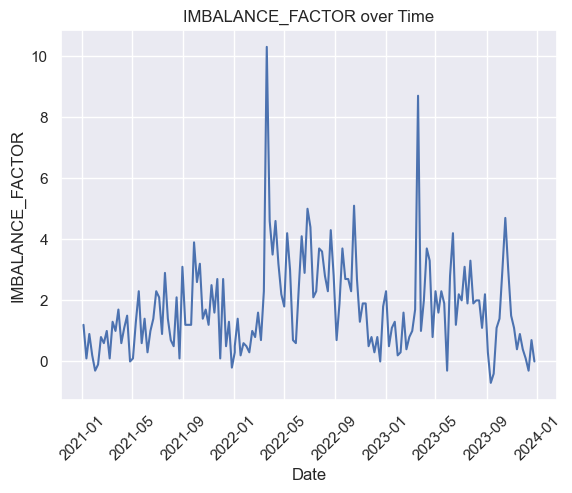

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.ylabel('IMBALANCE_FACTOR')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(station_data.index, station_data['IMBALANCE_FACTOR'], )
plt.title('IMBALANCE_FACTOR over Time')
plt.show()


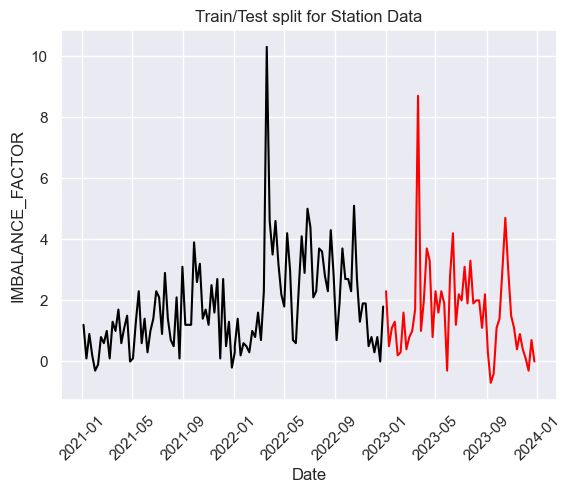

In [6]:
# Split into test and train data
# split data such that everything before November 2020 will serve as training data, 
# with everything after 2020 becoming the testing data

train = station_data[station_data.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]['IMBALANCE_FACTOR']
test = station_data[station_data.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]['IMBALANCE_FACTOR']

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('IMBALANCE_FACTOR')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Station Data")
plt.show()

In [7]:
# Autoregressive Moving Average (ARMA) Model
# The ARMA model is a combination of the Autoregressive (AR) and Moving Average (MA) models.
# The AR part models the relationship between an observation and a number of lagged observations (i.e., previous time steps).
# The MA part models the relationship between an observation and a residual error from a moving average model applied to lagged observations.
# The ARMA model is suitable for stationary time series data, meaning that the statistical properties of the series do not change over time.
# The ARMA model is defined by two parameters: p and q, where p is the number of lag observations (AR part) and q is the size of the moving average window (MA part).

# The ARMA model is defined as follows:
# Y(t) = c + φ1Y(t-1) + φ2Y(t-2) + ... + φpY(t-p) + θ1ε(t-1) + θ2ε(t-2) + ... + θqε(t-q) + ε(t)
# Where:
# Y(t) is the value at time t
# c is a constant
# φ1, φ2, ..., φp are the coefficients of the AR part
# θ1, θ2, ..., θq are the coefficients of the MA part
# ε(t) is the white noise error term
# The ARMA model is a linear model, meaning that it assumes a linear relationship between the input variables and the output variable.
# The ARMA model is a good choice for time series data that is stationary and has a linear relationship between the input and output variables.
# The ARMA model is not suitable for non-stationary time series data, meaning that the statistical properties of the series change over time.
# In such cases, the ARIMA (Autoregressive Integrated Moving Average) model is a better choice.
# The ARIMA model is an extension of the ARMA model that includes a differencing step to make the data stationary.


c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model wit

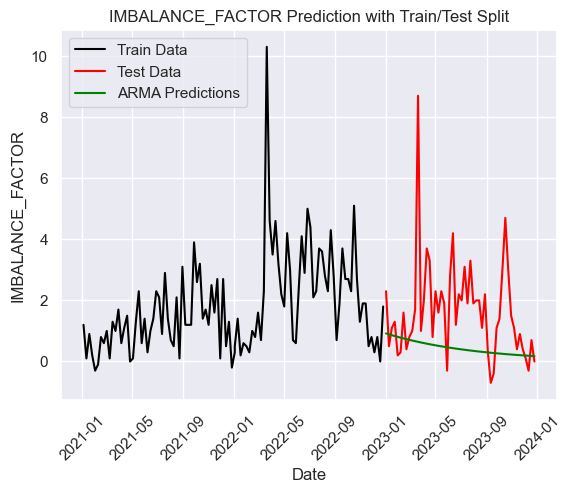

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = train  # Use the train series directly
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color="black", label="Train Data")
plt.plot(test, color="red", label="Test Data")
plt.plot(y_pred_out, color="green", label="ARMA Predictions")
plt.ylabel("IMBALANCE_FACTOR")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("IMBALANCE_FACTOR Prediction with Train/Test Split")
plt.legend()
plt.show()


In [9]:
# Evaluate result
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1.951352560420006


c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

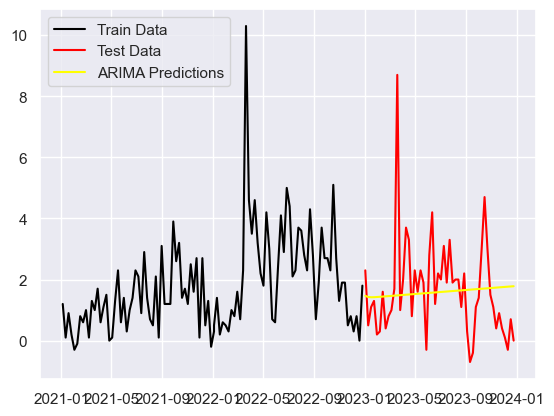

RMSE:  1.5694054155116026


In [10]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Fit the ARIMA model
ARIMAmodel = ARIMA(y, order=(2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

# Generate predictions
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

# Plot the results
plt.plot(train, color="black", label="Train Data")
plt.plot(test, color="red", label="Test Data")
plt.plot(y_pred_out, color="yellow", label="ARIMA Predictions")
plt.legend()
plt.show()

# Evaluate the result
arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ", arma_rmse)

c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting p

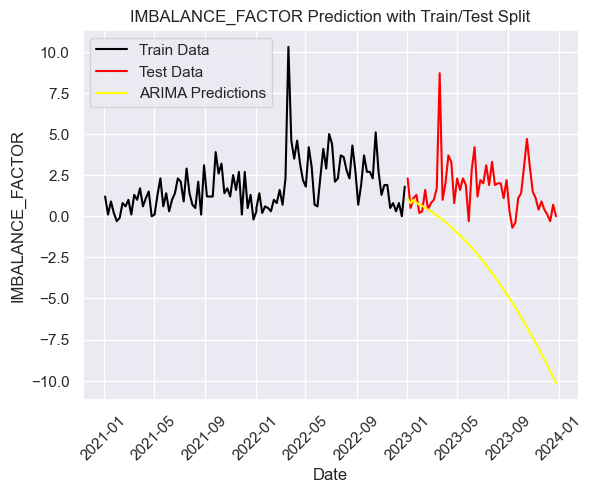

RMSE:  5.983402442921533


In [11]:
# We see that the ARIMA predictions (in yellow) fall on top of the ARMA predictions. 
# Let’s try increasing the differencing parameter to ARIMA (2,3,2)
ARIMAmodel = ARIMA(y, order=(2, 3, 2))
ARIMAmodel = ARIMAmodel.fit()
# Generate predictions
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
# Plot the results
plt.plot(train, color="black", label="Train Data")
plt.plot(test, color="red", label="Test Data")
plt.plot(y_pred_out, color="yellow", label="ARIMA Predictions")
plt.legend()
plt.ylabel("IMBALANCE_FACTOR")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("IMBALANCE_FACTOR Prediction with Train/Test Split")
plt.show()

# Evaluate the result
arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ", arma_rmse)


c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting p

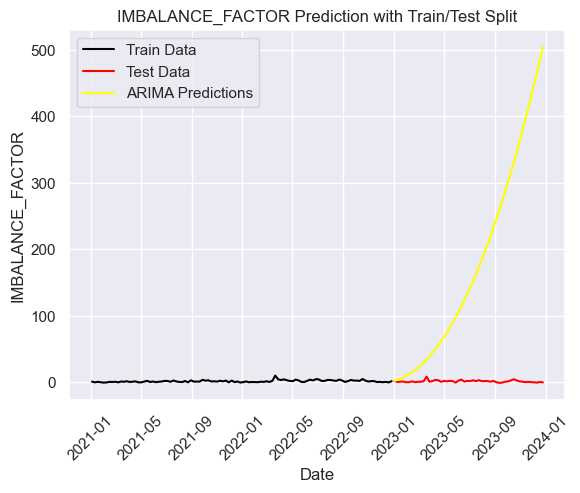

RMSE:  232.30482151810872


In [12]:
# We see this helps capture the increasing price direction. 
# Let’s try playing with the parameters even further with ARIMA(5,4,2)
ARIMAmodel = ARIMA(y, order=(5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()
# Generate predictions
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
# Plot the results
plt.plot(train, color="black", label="Train Data")
plt.plot(test, color="red", label="Test Data")
plt.plot(y_pred_out, color="yellow", label="ARIMA Predictions")
plt.legend()
plt.ylabel("IMBALANCE_FACTOR")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("IMBALANCE_FACTOR Prediction with Train/Test Split")
plt.show()

# Evaluate the result
arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ", arma_rmse)



Seasonal ARIMA (SARIMA) Model

c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  wa

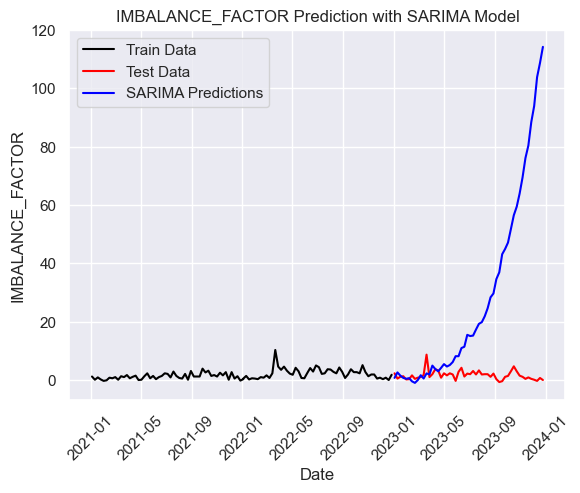

RMSE:  42.43836374602826


In [13]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train, color="black", label="Train Data")
plt.plot(test, color="red", label="Test Data")
plt.plot(y_pred_out, color="blue", label="SARIMA Predictions")
plt.ylabel("IMBALANCE_FACTOR")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("IMBALANCE_FACTOR Prediction with SARIMA Model")
plt.legend()
plt.show()

# Calculate and display RMSE
sarima_rmse = np.sqrt(mean_squared_error(test.values, y_pred_out.values))
print("RMSE: ", sarima_rmse)

c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\MP_Laptop\anaconda3\envs\EDA_Marc\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fa

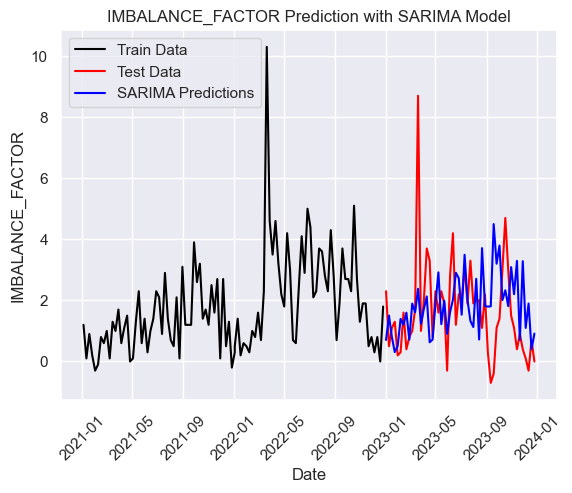

RMSE:  1.7743922203384377


In [14]:
# Example of adjusted SARIMA settings
SARIMAmodel = SARIMAX(train, order=(2, 1, 2), seasonal_order=(2, 1, 2, 52))
SARIMAmodel = SARIMAmodel.fit()

# Generate predictions
y_pred = SARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train, color="black", label="Train Data")
plt.plot(test, color="red", label="Test Data")
plt.plot(y_pred_out, color="blue", label="SARIMA Predictions")
plt.ylabel("IMBALANCE_FACTOR")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("IMBALANCE_FACTOR Prediction with SARIMA Model")
plt.legend()
plt.show()

# Calculate and display RMSE
sarima_rmse = np.sqrt(mean_squared_error(test.values, y_pred_out.values))
print("RMSE: ", sarima_rmse)
